# Practice - Tensorflow Datasets

# Tensorflow Datasets (Practice)

- For this assignment, you will be working with the Dangerous Farm Insects data set from Kaggle: https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset

The dataset has images of 15 different types of dangerous insects.

![img](https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1692317485__Screenshot20230817at81117PM.png)

## Getting Started

- Create a new GitHub repository for this assignment.
- Extract the downloaded data into a folder in your repository.
- Start a new Jupyter notebook for this assignment.

## Create a Tensorflor Image Dataset

- Create a Dataset using the tf.keras.image_dataset_from_directory function, using the following parameters:
    - label_model='categorical'  
    - image_height = 128
    - image_width=128
    - batch_size=32
    - a random seed

- Save the class_names and number of classes as variables to re-use later.
- Create a class_dict that has integers as the keys with the corresponding class names (sorted alphabetically)
- Split the dataset into a 70% training, 20 % validation, and 10% test split.
    - Hint: use .take() and .skip()

## Optimize the Dataset

- Add a shuffle step to the training dataset
- Add caching and prefetching to all 3 datasets
    - Note: if you have hardware issues using caching and prefetching, you may skip this requirement.

## Preview the Data 

- Retrieve a single batch of training data and save the first image's shape to use in your model's input_shape.
- Display an example image.

## Build a Simple CNN Model

- Build a simple Convolutional Neural Network with:

- 1\) a Rescaling layer

- 2\) Conv2D layer with:
    - 16 filters
    - Kernel size = 3
    - padding='same'

- 3\) MaxPooling Layer with:
    - pool_size=2

- 4\) Conv2D layer with:        
    - 32 filters
    - Kernel size = 3
    - padding='same'

- 5\) MaxPooling Layer with:
    - pool_size=2

- 6\) a flattening layer

- 7\) final Dense layer with appropriate settings (for the task):
    - the correct number of units
    - and activation function

- 8\) Compile the model with:
    - metrics=['accuracy']
    - optimizer='adam'
    - loss = "categorical_crossentropy"


![img](https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1692318050__practicedatasetscnn.png)

## Fit the Model

- Fit the model using:

    - the training ds as the training data,

    - Use the validation ds as the validation_data
    - 10 epochs

- Save the model.fit() history

## Evaluate the Model

- Plot the model's training history.
- Use the model.evaluate method to get the final test metrics.

## Solution Notebook

### Alternative: Using Rules of Thumb

Rules of Thumb for Selecting the Parameters for a CNN [Source](https://cs231n.github.io/convolutional-networks/):

- [x] The input layer (the input_shape of the first layer) should be divisible by 2 many times (e.g. 32, 64, 96, 224,385,512)
- Conv2D layers should use:
  -  A small filter_size (e.g. 3x3 or 5x5 at most)
  -  use a stride of 1
  -  use padding='same' (want no change in image size)

- Pooling layers should use:
    - pool_size = 2 (no larger than 3)
  - stride = 2
 

# SOLUTION CODE

In [1]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
tf.__version__

# Custom functions: add to lesson notebook instead of file
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("../Functions/"))

import ann_functions as af

### Create a Tensorflow Image Dataset

In [2]:
# Checking the contents of xrays folder
data_dir = "Data/Dangerous Insects/farm_insects/"
data_dir

'Data/Dangerous Insects/farm_insects/'

In [3]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1591

In [4]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(1250, 1000, 3)

In [5]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [6]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

ds

Found 1591 files belonging to 15 classes.
Metal device set to: Apple M1 Pro


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [7]:
len(ds)

50

In [8]:
## Set the size of the 
split_train = 0.7
split_val = 0.2
split_test = 0.1

# Calculate the number of batches for training and validation data 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 35 batches as training data
Use 10 batches as validation data
The remaining 5 batches will be used as test data.


In [9]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
len(train_ds)

35

In [10]:
## Create the val_ds from original ds

# 1. Skipping over the training batches
val_ds = ds.skip(n_train_batches)

# 2. Taking the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
len(val_ds)

10

In [11]:
# Create the test split from ds

# SKip over all of the training + val images
test_ds = ds.skip(n_train_batches + n_val_batches)
len(test_ds)

5

In [12]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

50

### Preview the Data

In [13]:
# checking the class names
class_names = ds.class_names

class_dict = dict(zip(range(len(class_names)), class_names))
class_dict

{0: 'Africanized Honey Bees (Killer Bees)',
 1: 'Aphids',
 2: 'Armyworms',
 3: 'Brown Marmorated Stink Bugs',
 4: 'Cabbage Loopers',
 5: 'Citrus Canker',
 6: 'Colorado Potato Beetles',
 7: 'Corn Borers',
 8: 'Corn Earworms',
 9: 'Fall Armyworms',
 10: 'Fruit Flies',
 11: 'Spider Mites',
 12: 'Thrips',
 13: 'Tomato Hornworms',
 14: 'Western Corn Rootworms'}

In [14]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

15

In [15]:
# Batch Size
batch_size

32

In [16]:
# taking a sample banch to see batch shape
example_batch_imgs,example_batch_y= train_ds.take(1).get_single_element()
example_batch_imgs.shape

2023-08-24 16:51:14.764209: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


TensorShape([32, 128, 128, 3])

In [17]:
# individual image shape
# individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

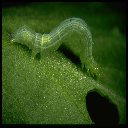

In [18]:
array_to_img(example_batch_imgs[0])

In [19]:
# Demo Unpacking shape
[*input_shape]

[128, 128, 3]

### Optimize Dataset Performance

In [20]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= train_ds.cardinality(),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training Baseline CNN

In [21]:
def build_model1(name='CNN1',input_shape=input_shape):
    
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=5,  # size of each filter
            input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    model.summary()
    return model

### Model 1: Basline Model

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0    

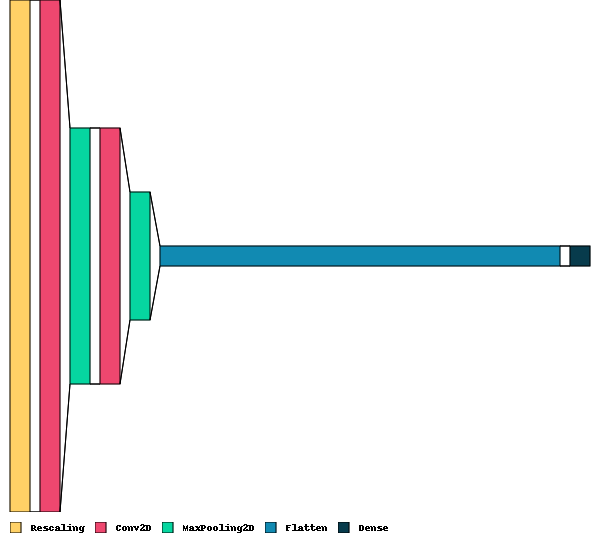

In [22]:
import visualkeras as vk
model1 = build_model1(name='Model1')
vk.layered_view(model1, legend=True, 
                draw_volume=False, 
                to_file='practice_datasets_cnn.png')

In [23]:
# Build fresh model and train
model1 = build_model1(name='Model1')

# fit the neural network
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, )

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0    

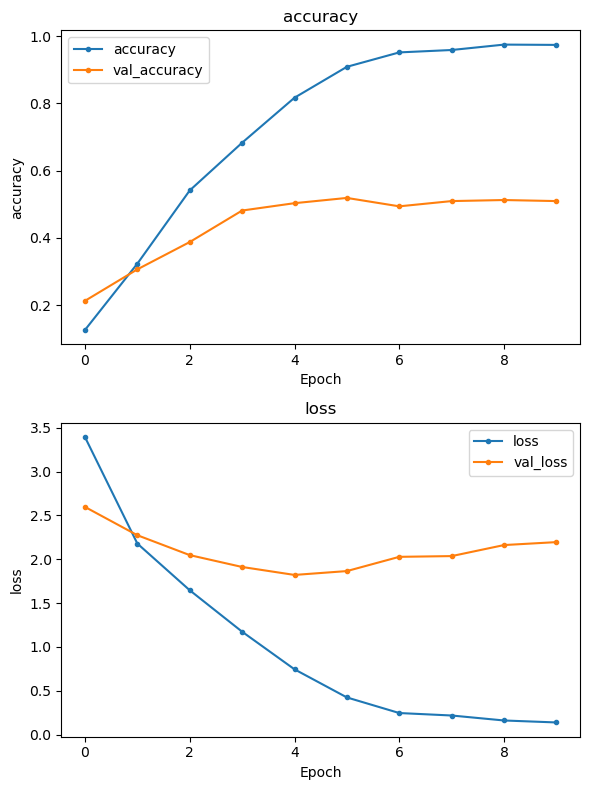

5/5 [==============================] - 0s 12ms/step - loss: 2.6207 - accuracy: 0.4437


{'loss': 2.6207427978515625, 'accuracy': 0.443708598613739}

In [25]:
af.plot_history(history)
model1.evaluate(test_ds, return_dict=True)

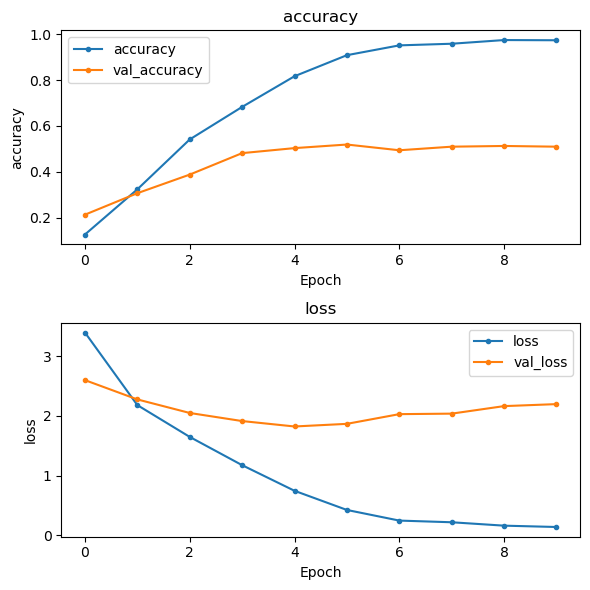


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.33      0.12      0.18         8
           2       0.09      0.12      0.11         8
           3       0.71      0.56      0.63         9
           4       0.40      0.55      0.46        11
           5       0.73      0.57      0.64        14
           6       0.67      0.55      0.60        11
           7       0.12      0.20      0.15         5
           8       0.67      0.43      0.52        14
           9       0.30      0.43      0.35         7
          10       0.46      0.67      0.55         9
          11       0.57      0.33      0.42        12
          12       0.29      0.67      0.40         9
          13       0.46      0.50      0.

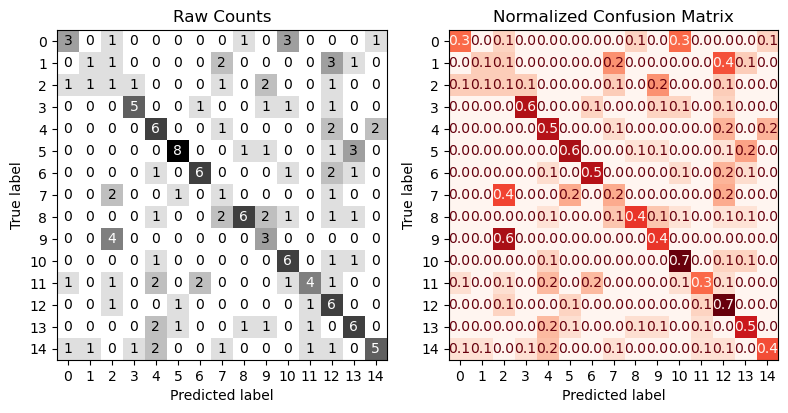


- Evaluating Test Data:
5/5 [==============================] - 0s 20ms/step - loss: 2.6207 - accuracy: 0.4437
{'loss': 2.6207427978515625, 'accuracy': 0.443708598613739}


In [24]:
# (Optional) Use evaluation function
af.evaluate_classification_network(model1, X_test=test_ds, history=history, figsize=(8,8),
                                  values_format=".1f");